In [1]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedGroupKFold,GroupKFold,train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')  
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

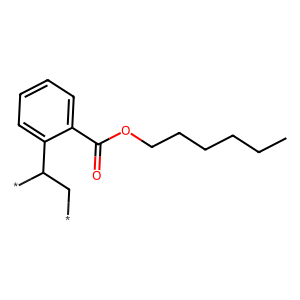

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles(train['SMILES'][0])
Draw.MolToImage(mol)

In [4]:
train.shape

(7973, 7)

In [5]:
train.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [6]:
train.isnull().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

In [7]:
train.describe(include="all")

,id,SMILES,Tg,FFV,Tc,Density,Rg
count,7.973000e+03,7973,511.000000,7030.000000,737.000000,613.000000,614.000000
unique,NaN,7973,NaN,NaN,NaN,NaN,NaN
top,NaN,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN
mean,1.080050e+09,NaN,96.452314,0.367212,0.256334,0.985484,16.419787
std,6.218241e+08,NaN,111.228279,0.029609,0.089538,0.146189,4.608640
min,8.781700e+04,NaN,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,5.376641e+08,NaN,13.674509,0.349549,0.186000,0.890243,12.540328
50%,1.079079e+09,NaN,74.040183,0.364264,0.236000,0.948193,15.052194
75%,1.621708e+09,NaN,161.147595,0.380790,0.330500,1.062096,20.411067


In [8]:
missing = train.isnull().sum()[['Tg', 'FFV', 'Tc', 'Density', 'Rg']]
missing

Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

### Getting features from rdkit

In [11]:
def compute_rdkit_feats(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    features = {}
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    
    for i in range(1, maccs.GetNumBits()):  # bit 0 is always 1
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))

    # Descriptors
    descs = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
        'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
        'NumRings': Descriptors.RingCount(mol),
        'NumRotatableBonds': CalcNumRotatableBonds(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'MolMR': Descriptors.MolMR(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol)
    }
    features.update(descs)

    return features

In [13]:
maccs_data = []

for smile in tqdm(train['SMILES']):
    feats = compute_rdkit_feats(smile)
    if feats is None:
        maccs_data.append(None)
    else:
        maccs_data.append(feats)
        
maccs_df = pd.DataFrame(maccs_data)
train_rdkit = pd.concat([train, maccs_df], axis=1)

  0%|          | 0/7973 [00:00<?, ?it/s]

In [14]:
train_rdkit.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg,MACCS_1,MACCS_2,MACCS_3,...,MolWt,TPSA,NumValenceElectrons,NumHeavyAtoms,NumRings,NumRotatableBonds,MolLogP,MolMR,NumHAcceptors,NumHDonors
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,0,0,0,...,232.323,26.30,92,17,1,8,3.98170,68.4145,2,0
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,0,0,0,...,598.919,24.06,236,45,5,16,12.35960,193.3954,2,2
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,0,0,0,...,1003.207,122.27,364,73,10,15,14.21700,281.6006,9,0
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,0,0,0,...,542.726,24.06,204,42,6,7,11.00768,179.8154,2,2
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,0,0,0,...,965.154,182.28,376,70,6,34,11.84500,266.9958,14,0


### Train baseline model

In [19]:
rdkit_cols = train_rdkit.columns.tolist()[7:]
targets = train_rdkit.columns.tolist()[2:7]

In [20]:
models = {}
preds = {}
maes = {}
true_vals = {}
ranges = {}

for target in targets:
    print(f'training model for {target}')
    df = train_rdkit[rdkit_cols + [target]].dropna()
    X = df[rdkit_cols]
    y = df[target]
    
    ranges[target] = y.max() - y.min()
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    #predict and save
    y_pred = model.predict(X_val)
    preds[target] = y_pred
    true_vals[target] = y_val.values
    maes[target] = mean_absolute_error(y_val, y_pred)
    
    models[target] = model
    print(f"MAE: {maes[target]:.4f}")

training model for Tg
MAE: 52.8119
training model for FFV
MAE: 0.0076
training model for Tc
MAE: 0.0308
training model for Density
MAE: 0.0390
training model for Rg
MAE: 2.0663


### Compute competition metric (wMAE)

In [21]:
# Count available samples (n_i) for each target
n_samples = {t: len(true_vals[t]) for t in targets}
K = len(targets)

# compute w_i per target
weights = {}
sqrt_inv = [np.sqrt(1/n_samples[t]) for t in targets]
normalizer = K / sum(sqrt_inv)

for t in targets:
    r_i = ranges[t]
    w_i = (1 / r_i) * (normalizer * np.sqrt(1 / n_samples[t]))
    weights[t] = w_i
    
# final weighted mae
wmae = sum(weights[t] * maes[t] for t in targets)

In [22]:
wmae

0.31907064997692136

In [23]:
print("\n Per-target MAEs:")
for t in targets:
    print(f"{t:<10} MAE: {maes[t]:.4f} | Weight: {weights[t]:.4f}")

print(f"\n Final Weighted MAE (Competition Metric): {wmae:.4f}")



 Per-target MAEs:
Tg         MAE: 52.8119 | Weight: 0.0020
FFV        MAE: 0.0076 | Weight: 0.6252
Tc         MAE: 0.0308 | Weight: 2.2199
Density    MAE: 0.0390 | Weight: 1.0645
Rg         MAE: 2.0663 | Weight: 0.0466

 Final Weighted MAE (Competition Metric): 0.3191


In [25]:
maccs_data_test = []

for smile in tqdm(test['SMILES']):
    feats = compute_rdkit_feats(smile)
    if feats is None:
        maccs_data_test.append(None)
    else:
        maccs_data_test.append(feats)
        
maccs_df_test = pd.DataFrame(maccs_data_test)
test_rdkit = pd.concat([test, maccs_df_test], axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
test_rdkit.head()

,id,SMILES,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,...,MolWt,TPSA,NumValenceElectrons,NumHeavyAtoms,NumRings,NumRotatableBonds,MolLogP,MolMR,NumHAcceptors,NumHDonors
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...,0,0,0,0,0,0,0,0,...,540.463,43.18,198,39,4,8,7.3603,134.182,4,0
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...,0,0,0,0,0,0,0,0,...,510.589,52.60,190,39,5,9,7.2845,151.539,4,0
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...,0,0,0,0,0,0,0,0,...,586.644,93.22,220,44,6,13,6.1875,164.728,6,0


In [27]:
X_test = test_rdkit[rdkit_cols]

for target in targets:
    print(f'predicting for {target}')
    model = models[target]
    y_pred = model.predict(X_test)
    test_rdkit[target] = y_pred

submission_df = test_rdkit[['id'] + targets]

predicting for Tg
predicting for FFV
predicting for Tc
predicting for Density
predicting for Rg


In [28]:
submission_df

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,132.643668,0.376766,0.149337,1.202208,20.288178
1,1422188626,144.624659,0.381611,0.225495,1.082822,20.994577
2,2032016830,90.975971,0.350081,0.285003,1.100660,21.113914


In [33]:
submission_df.to_csv('RandomForest_BaseLine.csv', index=False)